In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold
import copy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.preprocessing import LabelEncoder

In [5]:
class AttentionBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.4):
        super(AttentionBiLSTMClassifier, self).__init__()
        
        # Embedding layer with dropout
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(dropout)
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, 
            num_layers=n_layers, 
            bidirectional=True, 
            batch_first=True, 
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        x = self.embed_dropout(x)
        
        # BiLSTM
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global max pooling and global average pooling
        max_pool = torch.max(attn_out, dim=1)[0]
        avg_pool = torch.mean(attn_out, dim=1)
        
        # Concatenate pooled features
        pooled = max_pool + avg_pool  # Element-wise addition instead of concat
        
        # Batch normalization
        if pooled.size(0) > 1:  # Only apply batch norm if batch size > 1
            pooled = self.batch_norm(pooled)
        
        # Classification
        out = self.classifier(pooled)
        return torch.sigmoid(out)

In [6]:
import json
import pandas as pd
# ------------------------
# 1. LRP Wrapper for Existing Model
# ------------------------

class TextDataset:
    """
    Custom PyTorch Dataset class for handling text data
    
    This class converts your preprocessed text data into a format
    that PyTorch can use for training and testing
    """
    
    def __init__(self, X, y):
        """
        Initialize the dataset
        
        Args:
            X: numpy array of shape (num_samples, max_sequence_length)
               Contains tokenized and padded sequences
            y: numpy array of shape (num_samples,)
               Contains labels (0 for non-hallucination, 1 for hallucination)
        """
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.long)    # Long integers for token IDs
        self.y = torch.tensor(y, dtype=torch.float)   # Float for binary classification
    
    def __len__(self):
        """
        Returns the total number of samples in the dataset
        Required method for PyTorch Dataset
        """
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        Returns a single sample (input, label) at the given index
        Required method for PyTorch Dataset
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            tuple: (input_sequence, label)
        """
        return self.X[idx], self.y[idx]
    
data_list = []
with open("general_data.json", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            data_list.append(json.loads(line))

df = pd.DataFrame(data_list)

MAX_VOCAB = 50000  # Increased vocabulary
MAX_LEN = 512  

In [7]:
def preprocess_text(text):
    """Enhanced text preprocessing"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep punctuation that might be meaningful
    text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
    
    return text.strip()    # Increased sequence length

df['user_query_clean'] = df['user_query'].apply(preprocess_text)
df['chatgpt_response_clean'] = df['chatgpt_response'].apply(preprocess_text)

df['text'] = df['user_query_clean'] + " [SEP] " + df['chatgpt_response_clean']

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>", char_level=False)
tokenizer.fit_on_texts(df['text'].tolist())

le = LabelEncoder()
df['label'] = le.fit_transform(df['hallucination'])

sequences = tokenizer.texts_to_sequences(df['text'].tolist())
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    
X_temp, X_test, y_temp, y_test = train_test_split(
    padded_sequences, df['label'].values, 
    test_size=0.15, random_state=42, stratify=df['label']
)

In [8]:
class LRPModelWrapper:
    """
    Wrapper to add LRP capabilities to your existing trained model
    without retraining
    """
    
    def __init__(self, trained_model, tokenizer):
        self.original_model = trained_model
        self.tokenizer = tokenizer
        self.device = next(trained_model.parameters()).device
        
        # Create reverse word mapping
        self.index_to_word = {v: k for k, v in tokenizer.word_index.items()}
        self.index_to_word[0] = '<PAD>'
        
        # Storage for intermediate activations
        self.activations = {}
        self.gradients = {}
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture activations and gradients"""
        
        def get_activation(name):
            def hook(model, input, output):
                if isinstance(input, tuple):
                    self.activations[name + '_input'] = input[0].detach()
                else:
                    self.activations[name + '_input'] = input.detach()
                
                if isinstance(output, tuple):
                    self.activations[name] = output[0].detach()
                else:
                    self.activations[name] = output.detach()
            return hook
        
        def get_gradient(name):
            def hook(grad):
                self.gradients[name] = grad.detach()
            return hook
        
        # Hook embedding layer
        self.original_model.embedding.register_forward_hook(get_activation('embedding'))
        
        # Hook LSTM layer
        self.original_model.lstm.register_forward_hook(get_activation('lstm'))
        
        # Hook attention if it exists
        if hasattr(self.original_model, 'attention'):
            self.original_model.attention.register_forward_hook(get_activation('attention'))
        
        # Hook classifier layers
        if hasattr(self.original_model, 'classifier'):
            for i, layer in enumerate(self.original_model.classifier):
                if isinstance(layer, (nn.Linear, nn.ReLU)):
                    layer.register_forward_hook(get_activation(f'classifier_{i}'))
        
        # Hook batch norm if it exists
        if hasattr(self.original_model, 'batch_norm'):
            self.original_model.batch_norm.register_forward_hook(get_activation('batch_norm'))
    
    def forward_with_hooks(self, x):
        """Forward pass while storing activations"""
        self.activations.clear()
        with torch.no_grad():
            output = self.original_model(x)
        return output

In [9]:
class UniversalLRPExplainer:
    """
    Gradient-based explainer for any BiLSTM model with embeddings.
    Supports vanilla gradients, integrated gradients, and simplified LRP.
    """

    def __init__(self, model_wrapper):
        self.wrapper = model_wrapper
        self.model = model_wrapper.original_model
        self.tokenizer = model_wrapper.tokenizer
        self.index_to_word = model_wrapper.index_to_word

    def explain(self, input_ids, target_class=None, method='integrated_gradients', steps=50):
        """
        Explain model prediction using gradient-based attribution.

        Args:
            input_ids: torch.LongTensor of token IDs (1D or 2D)
            target_class: class to explain (optional)
            method: 'gradients', 'integrated_gradients', 'guided_backprop', or 'lrp'
            steps: steps for Integrated Gradients
        """
        input_ids = input_ids.unsqueeze(0) if input_ids.dim() == 1 else input_ids
        input_ids = input_ids.to(self.wrapper.device)

        # Forward pass to get prediction
        with torch.no_grad():
            output = self.model(input_ids)
        predicted_class = (output > 0.5).int().item()
        prediction_prob = output.item()

        if target_class is None:
            target_class = predicted_class

        # Compute attributions
        if method == 'gradients':
            attributions = self._vanilla_gradients(input_ids)
        elif method == 'integrated_gradients':
            attributions = self._integrated_gradients(input_ids, steps=steps)
        elif method == 'lrp':
            attributions = self._lrp_approximation(input_ids)
        else:
            raise ValueError(f"Unknown method: {method}")

        token_relevances = self._get_token_attributions(attributions, input_ids)

        return {
            'token_relevances': token_relevances,
            'predicted_class': predicted_class,
            'prediction_prob': prediction_prob,
            'input_tokens': self._ids_to_tokens(input_ids.squeeze()),
            'attribution_sum': token_relevances.sum()
        }

    def _vanilla_gradients(self, input_ids):
        embeddings = self.model.embedding(input_ids).float()
        embeddings.requires_grad_(True)
        embeddings.retain_grad()

        output = self._forward_from_embeddings(embeddings)
        output.backward(retain_graph=True)

        gradients = embeddings.grad
        attributions = gradients * embeddings
        return attributions

    def _integrated_gradients(self, input_ids, steps=50):
        baseline_ids = torch.zeros_like(input_ids).to(self.wrapper.device)

        attributions_list = []
        for alpha in torch.linspace(0, 1, steps).to(self.wrapper.device):
            interpolated_ids = (baseline_ids + alpha * (input_ids - baseline_ids)).long()
            embeddings = self.model.embedding(interpolated_ids).float()
            embeddings.requires_grad_(True)
            embeddings.retain_grad()

            output = self._forward_from_embeddings(embeddings)
            output.backward(retain_graph=True)

            attributions_list.append(embeddings.grad.clone())
            embeddings.grad.zero_()

        avg_gradients = torch.stack(attributions_list).mean(dim=0)
        input_embeddings = self.model.embedding(input_ids).float()
        baseline_embeddings = self.model.embedding(baseline_ids).float()
        integrated_gradients = avg_gradients * (input_embeddings - baseline_embeddings)

        return integrated_gradients

    def _lrp_approximation(self, input_ids):
        embeddings = self.model.embedding(input_ids).float()
        embeddings.requires_grad_(True)
        embeddings.retain_grad()

        output = self._forward_from_embeddings(embeddings)
        output.backward(retain_graph=True)

        return embeddings.grad * embeddings

    def _forward_from_embeddings(self, embeddings):
        x = self.model.embed_dropout(embeddings) if hasattr(self.model, 'embed_dropout') else embeddings
        return self._forward_from_lstm_input(x)

    def _forward_from_lstm_input(self, x):
        lstm_out, _ = self.model.lstm(x) if hasattr(self.model, 'lstm') else (x, None)
        return self._forward_from_lstm(lstm_out)

    def _forward_from_lstm(self, lstm_out):
        if hasattr(self.model, 'attention'):
            attn_out, _ = self.model.attention(lstm_out, lstm_out, lstm_out)
            attended = torch.mean(attn_out, dim=1)
        else:
            if hasattr(self.model, 'batch_norm'):
                max_pool = torch.max(lstm_out, dim=1)[0]
                avg_pool = torch.mean(lstm_out, dim=1)
                attended = max_pool + avg_pool
            else:
                attended = lstm_out[:, -1, :]

        if hasattr(self.model, 'batch_norm') and attended.size(0) > 1:
            attended = self.model.batch_norm(attended)
        output = self.model.classifier(attended) if hasattr(self.model, 'classifier') else attended
        return output

    def _get_token_attributions(self, attributions, input_ids):
        token_attrs = attributions.sum(dim=-1).squeeze(0)
        mask = (input_ids.squeeze() != 0).float()
        return (token_attrs * mask).detach().cpu().numpy()

    def _ids_to_tokens(self, input_ids):
        tokens = []
        for idx in input_ids.cpu().numpy():
            tokens.append(self.index_to_word.get(idx, '<UNK>'))
        return tokens


In [10]:
class LRPVisualizer:
    """Visualization utilities for attribution results"""
    
    def __init__(self, explainer):
        self.explainer = explainer
    
    def plot_token_relevance(self, explanation, title="Token Attribution Scores", figsize=(12, 6)):
        """Plot token attribution scores"""
        tokens = explanation['input_tokens']
        relevances = explanation['token_relevances']
        
        # Filter out padding tokens
        non_pad_mask = [token != '<PAD>' for token in tokens]
        tokens_filtered = [tokens[i] for i in range(len(tokens)) if non_pad_mask[i]]
        relevances_filtered = relevances[non_pad_mask]
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot attributions
        colors = ['red' if r < 0 else 'green' for r in relevances_filtered]
        bars = ax.bar(range(len(tokens_filtered)), relevances_filtered, color=colors, alpha=0.7)
        ax.set_title(title)
        ax.set_ylabel('Attribution Score')
        ax.set_xlabel('Tokens')
        ax.set_xticks(range(len(tokens_filtered)))
        ax.set_xticklabels(tokens_filtered, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, relevances_filtered):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
                   f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
        
        plt.tight_layout()
        return fig
    
    def compare_methods(self, input_ids, methods=['gradients', 'integrated_gradients'], figsize=(15, 8)):
        """Compare different attribution methods"""
        explanations = []
        titles = []
        
        for method in methods:
            explanation = self.explainer.explain(input_ids, method=method)
            explanations.append(explanation)
            titles.append(f"{method.replace('_', ' ').title()}")
        
        fig, axes = plt.subplots(len(methods), 1, figsize=figsize)
        if len(methods) == 1:
            axes = [axes]
        
        for i, (explanation, title) in enumerate(zip(explanations, titles)):
            tokens = explanation['input_tokens']
            relevances = explanation['token_relevances']
            
            # Filter padding
            non_pad_mask = [token != '<PAD>' for token in tokens]
            tokens_filtered = [tokens[j] for j in range(len(tokens)) if non_pad_mask[j]]
            relevances_filtered = relevances[non_pad_mask]
            
            # Plot
            colors = ['red' if r < 0 else 'green' for r in relevances_filtered]
            axes[i].bar(range(len(tokens_filtered)), relevances_filtered, color=colors, alpha=0.7)
            axes[i].set_title(f"{title} (Pred: {explanation['predicted_class']}, Prob: {explanation['prediction_prob']:.3f})")
            axes[i].set_ylabel('Attribution')
            axes[i].set_xticks(range(len(tokens_filtered)))
            axes[i].set_xticklabels(tokens_filtered, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


Loading existing trained model...
Creating LRP wrapper...
Generating explanations...


C:\Users\SARTHAK\AppData\Local\Temp\ipykernel_9288\1425984320.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=


GRADIENTS Results:
Prediction: 0 (prob: 0.150)
Top positive attributions:
  <UNK>: 0.0278
  <UNK>: 0.0205
  <UNK>: 0.0146
  <UNK>: 0.0134
  <UNK>: 0.0116
Top negative attributions:
  <UNK>: -0.0107
  <UNK>: -0.0106
  <UNK>: -0.0090
  <UNK>: -0.0089
  <UNK>: -0.0082

INTEGRATED_GRADIENTS Results:
Prediction: 0 (prob: 0.150)
Top positive attributions:
  <UNK>: 0.0130
  <UNK>: 0.0119
  <UNK>: 0.0115
  <UNK>: 0.0107
  <UNK>: 0.0106
Top negative attributions:
  <UNK>: -0.0098
  <UNK>: -0.0091
  <UNK>: -0.0089
  <UNK>: -0.0089
  <UNK>: -0.0085


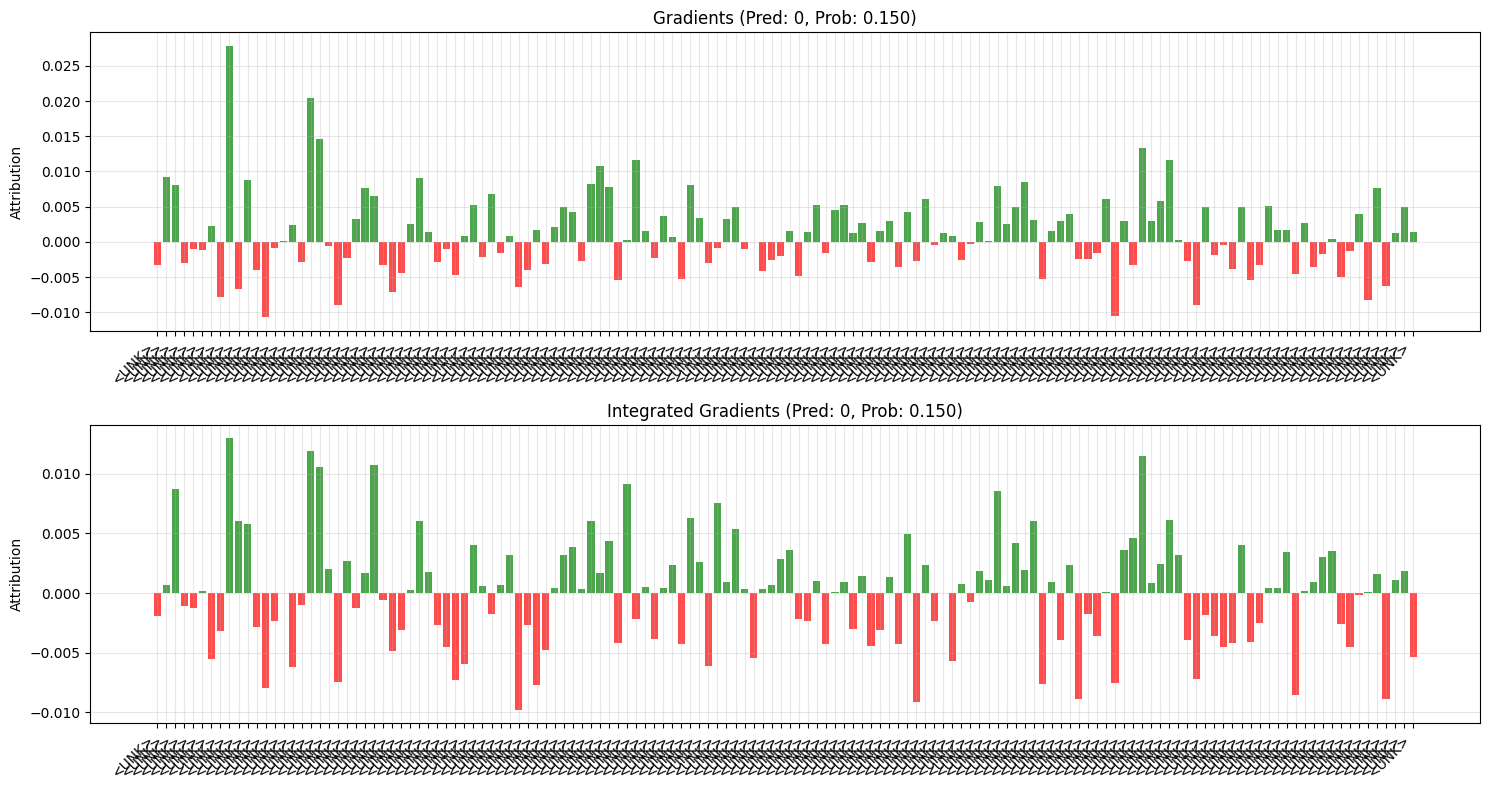

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [14]:
def load_and_explain_existing_model(model_path, tokenizer, test_sample):
    """
    Load your existing trained model and add LRP capabilities
    """
    print("Loading existing trained model...")
    
    # Import your original model class (make sure it's available)
# Adjust import as needed
    
    # Initialize model with same parameters used during training
    VOCAB_SIZE = 50000  # Adjust as needed
    EMBED_DIM = 256
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    
    model = AttentionBiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()
    
    print("Creating LRP wrapper...")
    
    # Create wrapper and explainer
    wrapper = LRPModelWrapper(model, tokenizer)
    explainer = UniversalLRPExplainer(wrapper)
    visualizer = LRPVisualizer(explainer)
    
    print("Generating explanations...")
    
    # Generate explanations using different methods
    methods = ['gradients', 'integrated_gradients']
    
    for method in methods:
        explanation = explainer.explain(test_sample, method=method)
        
        print(f"\n{method.upper()} Results:")
        print(f"Prediction: {explanation['predicted_class']} (prob: {explanation['prediction_prob']:.3f})")
        
        # Find most important tokens
        tokens = explanation['input_tokens']
        relevances = explanation['token_relevances']
        
        # Get top positive and negative attributions
        non_pad_mask = np.array([token != '<PAD>' for token in tokens])
        filtered_relevances = relevances[non_pad_mask]
        filtered_tokens = np.array(tokens)[non_pad_mask]
        
        top_positive_idx = np.argsort(filtered_relevances)[-5:]
        top_negative_idx = np.argsort(filtered_relevances)[:5]
        
        print("Top positive attributions:")
        for idx in reversed(top_positive_idx):
            print(f"  {filtered_tokens[idx]}: {filtered_relevances[idx]:.4f}")
        
        print("Top negative attributions:")
        for idx in top_negative_idx:
            print(f"  {filtered_tokens[idx]}: {filtered_relevances[idx]:.4f}")
    
    # Create comparison visualization
    fig = visualizer.compare_methods(test_sample, methods)
    plt.savefig(f'attribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return wrapper, explainer, visualizer

tokenizer = Tokenizer(num_words=20000 , oov_token="<OOV>", char_level=False)

data_list = []
with open("general_data.json", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            data_list.append(json.loads(line))

df = pd.DataFrame(data_list)


test_dataset = TextDataset(X_test , y_test)

# Load your existing model with LRP capabilities
wrapper, explainer, visualizer = load_and_explain_existing_model(
    'best_model.pth',  # Your existing trained model
    tokenizer,         # Your existing tokenizer
    test_dataset[0][0] # Any test sample
)

# Explain any prediction
sample = test_dataset[8][1]
explanation = explainer.explain(sample, method='integrated_gradients')

# Visualize
fig = visualizer.plot_token_relevance(explanation)
plt.show()